In [1]:
import nibabel as nib
import numpy as np
import h5py
import glob
import os
import pandas as pd
from scipy.signal import resample, resample_poly, decimate
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt
import seaborn as sns
from fractions import Fraction
import math
from tqdm import tqdm
import colorednoise as cn

In [2]:
def ts_resample(timeseries, TR_new, TR_org=None, time=None, method='poly', axis=-1):

    n_tp = timeseries.shape[axis] # number of timepoints
    ratio = TR_org/TR_new

    if (TR_org == None) and (time == None):
        raise Exception('TR_org and time cannot be None at the same time')
    
    if TR_org == None:
        TR_org = time[1]-time[0]

    if method == 'fft':
        ts_resampled = resample(timeseries, t=time, axis=axis, num=int(TR_org/TR_new*n_tp))
    elif method == 'poly':
        fraq = Fraction(ratio)
        ts_resampled = resample_poly(timeseries, up=fraq.numerator, down=fraq.denominator, axis=axis)
    #elif method == '':

    time_resampled = np.arange(0, n_tp*TR_org, TR_new)
    return ts_resampled, time_resampled

In [3]:
# Load functional data and atals file
func_gii = nib.load('sub-0001_hemi-R_task-movie_run-1_space-fsLR_den-32k_desc-denoised_fwhm-0_confounds-1_bold.func.gii')
data = np.vstack([d.data for d in func_gii.darrays])

TR_org = 1.25
TR_new = 2
time = np.arange(0,TR_org*data.shape[0],TR_org)

data_resampled_fft, _ = ts_resample(data, TR_new, TR_org, method='fft')
data_resampled_poly, time_resampled = ts_resample(data, TR_new, TR_org, method='poly')

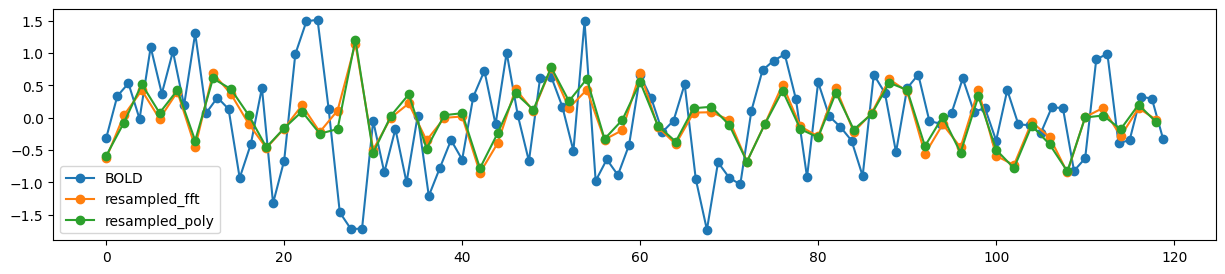

In [37]:
vertex = 2550
length = 120
ind_org = math.ceil(length/TR_org)
ind_down = math.ceil(length/TR_new)

plt.figure(figsize=(15,3))
plt.plot(time[:ind_org], data[:ind_org,vertex], marker='o', label='BOLD')
plt.plot(time_resampled[:ind_down], data_resampled_fft[:ind_down,vertex], marker='o', label='resampled_fft')
plt.plot(time_resampled[:ind_down], data_resampled_poly[:ind_down,vertex], marker='o', label='resampled_poly')
#plt.plot(time_resampled[:ind_down], data_resampled_my[:ind_down,vertex], marker='o', label='resampled_my')
#plt.plot(t_upsampled[:500], data_upsampled[:500,vertex], label='upsampled')
plt.legend()


In [5]:
from scipy.stats import gamma

# Function to create a canonical (double gamma) hemodynamic response function
def hrf(timestep):
    # Generate time vector
    t = np.arange(0,30,timestep)
    # Parameters for the canonical HRF
    n1 = gamma.pdf(t, 6)
    n2 = gamma.pdf(t, 16)
    return n1 - 0.35 * n2

def simulate_bold(total_time=120, timestep=0.05, rate=1, n=1):
    # Create a time vector
    t = np.arange(0, total_time, timestep)
    # Simulate a simple neural activation signal (e.g., stimulus at t=5s and t=15s)
    neural = np.random.poisson(rate*timestep, size=(n,t.shape[0])).astype('float')
    # Convolve the neural signal with the HRF
    hrf_signal = hrf(timestep)
    bold = convolve1d(neural, hrf_signal, origin=-math.floor(len(hrf_signal)/2), axis=-1)
    # Remove mean
    bold -= bold.mean(axis=0)

    return t, neural, bold

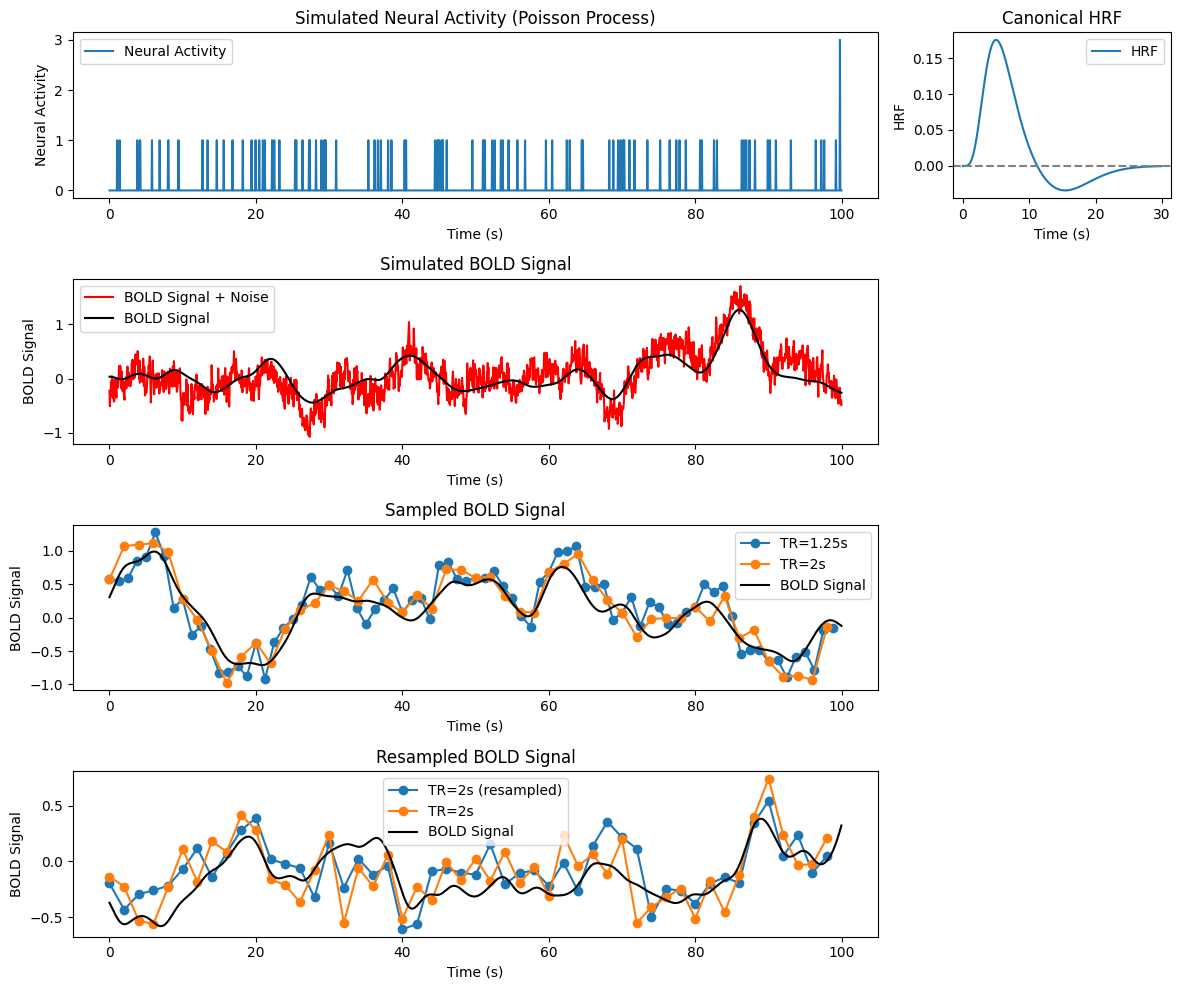

In [38]:
# Parameters
n = 5             # number of simulations
total_time = 100  # total simulation time in seconds
timestep = 0.05   # time resolution in seconds
rate = 1          # average rate of neural activations per second
sigma = 0.25       # noise sigma
noisetype = 'pink'

t, neural, bold = simulate_bold(total_time=total_time, timestep=timestep, rate=1, n=5)

n_tp = bold.shape[1]

if noisetype == 'white':
    noise = sigma * np.random.randn(n, n_tp)
elif noisetype == 'pink':
    noise = sigma * cn.powerlaw_psd_gaussian(1, (n, n_tp))
elif noisetype == 'brown':
    noise = sigma * cn.powerlaw_psd_gaussian(2, (n, n_tp))

# Add noise to bold signal
bold_noisy = bold + noise

# Sample BOLD to TR1
TR1 = 1.25
q = int(TR1/timestep)
bold1 = bold_noisy[:,::q]
time1 = t[::q]

# Sample BOLD to TR2
TR2 = 2
q = int(TR2/timestep)
bold2 = bold_noisy[:,::q]
time2 = t[::q]

# Resample lower TR to higher TR
bold1_resampled, _ = ts_resample(bold1, TR2, TR1)

i = 2

# Plotting
plt.style.use('default')
# plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4,4)
axes = []
axes.append(fig.add_subplot(gs[0, :3]))
axes.append(fig.add_subplot(gs[0, 3]))
axes.append(fig.add_subplot(gs[1, :3]))
axes.append(fig.add_subplot(gs[2, :3]))
axes.append(fig.add_subplot(gs[3, :3]))

i = 0
axes[i].plot(t, neural[i,:], label='Neural Activity')
axes[i].set_xlabel('Time (s)')
axes[i].set_ylabel('Neural Activity')
axes[i].set_title('Simulated Neural Activity (Poisson Process)')
axes[i].legend()

i = 1
axes[i].plot(t[:math.floor(30/timestep)], hrf(timestep), label='HRF')
axes[i].axhline(0, linestyle='--', color='gray')
axes[i].set_xlabel('Time (s)')
axes[i].set_ylabel('HRF')
axes[i].set_title('Canonical HRF')
axes[i].legend()

i = 2
axes[i].plot(t, bold_noisy[i,:], label='BOLD Signal + Noise', color='red')
axes[i].plot(t, bold[i,:], label='BOLD Signal', color='black')
axes[i].set_xlabel('Time (s)')
axes[i].set_ylabel('BOLD Signal')
axes[i].set_title('Simulated BOLD Signal')
axes[i].legend()

i = 3
axes[i].plot(time1, bold1[i,:], label='TR=1.25s', marker='o')
axes[i].plot(time2, bold2[i,:], label='TR=2s', marker='o')
axes[i].plot(t, bold[i,:], label='BOLD Signal', color='black')
axes[i].set_xlabel('Time (s)')
axes[i].set_ylabel('BOLD Signal')
axes[i].set_title('Sampled BOLD Signal')
axes[i].legend()

i = 4
axes[i].plot(time2, bold1_resampled[i,:], label='TR=2s (resampled)', marker='o')
axes[i].plot(time2, bold2[i,:], label='TR=2s', marker='o')
axes[i].plot(t, bold[i,:], label='BOLD Signal', color='black')
axes[i].set_xlabel('Time (s)')
axes[i].set_ylabel('BOLD Signal')
axes[i].set_title('Resampled BOLD Signal')
axes[i].legend()

plt.tight_layout()
plt.show()

In [49]:
mse = np.mean(np.square(bold1_resampled - bold2))

C = []
for i in range(bold2.shape[0]):
    C.append(np.corrcoef(bold1_resampled[i,:], bold2[i,:], rowvar=True)[0,1])

In [26]:
def noise_simulation(total_time=100, timestep=0.05, rate=1, n=100, noisetype='white'):
    # Simulate neural activation and BOLD signal (n=100 simulations)
    _, _, bold = simulate_bold(total_time=total_time, timestep=timestep, rate=rate, n=n)

    n_tp = bold.shape[1]

    sigma = np.arange(0,1,0.01)
    mse = []
    corr = []

    # Add noise with different SNRs
    for s in tqdm(sigma):
        
        # Generate noise
        if noisetype == 'white':
            noise = s * np.random.randn(n, n_tp)
        elif noisetype == 'pink':
            noise = s * cn.powerlaw_psd_gaussian(1, (n, n_tp))
        elif noisetype == 'brown':
            noise = s * cn.powerlaw_psd_gaussian(2, (n, n_tp))

        # Add noise to bold signal
        bold_noisy = bold + noise

        # Sample BOLD to TR1
        TR1 = 1.25
        q = int(TR1/timestep)
        bold1 = bold_noisy[:,::q]

        # Sample BOLD to TR2
        TR2 = 2
        q = int(TR2/timestep)
        bold2 = bold_noisy[:,::q]

        # Resample lower TR to higher TR
        bold1_resampled, _ = ts_resample(bold1, TR2, TR1)

        # Calculate resampling mse
        mse.append(np.mean(np.square(bold1_resampled - bold2)))

        # Calculate resampling correlation
        C = [np.corrcoef(bold1_resampled[i,:], bold2[i,:], rowvar=True)[0,1] for i in range(n)]

        corr.append(np.array(C).mean())

    return sigma, mse, corr


100%|██████████| 100/100 [00:00<00:00, 205.77it/s]


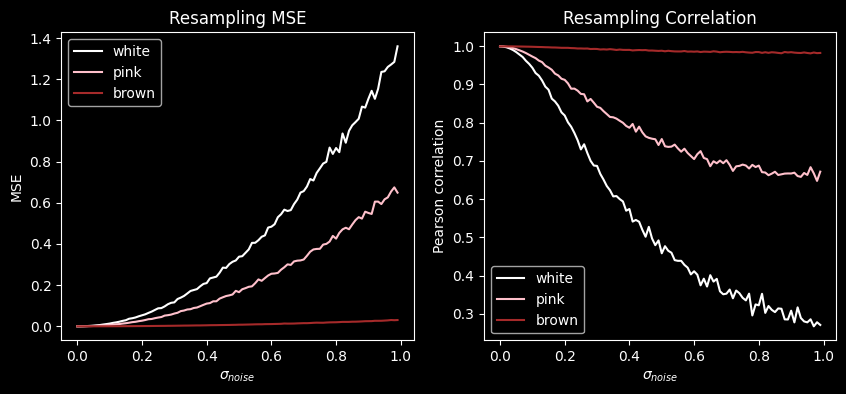

In [25]:
noisetypes = ['white', 'pink', 'brown']

plt.style.use('dark_background')
fig = plt.figure(figsize=(10,4))
axes = fig.subplots(1,2)

for i, noisetype in enumerate(noisetypes):
    sigma, mse, corr = noise_simulation(noisetype=noisetype)
    axes[0].plot(sigma,mse,label=noisetype, color=noisetype)
    axes[0].set_title('Resampling MSE')
    axes[0].set_ylabel('MSE')
    axes[0].set_xlabel('$\sigma_{noise}$')
    axes[0].legend()
    axes[1].plot(sigma,corr,label=noisetype, color=noisetype)
    axes[1].set_title('Resampling Correlation')
    axes[1].set_ylabel('Pearson correlation')
    axes[1].set_xlabel('$\sigma_{noise}$')
    axes[1].legend()
    